In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('../gains'))
if module_path not in sys.path:
        sys.path.append(module_path)
import localGains as genetic
# import gains as genetic
import pandas as pd
import rdkit
import pickle
from math import exp
import numpy as np
import random
import unittest
import datetime
import sys
import sklearn

from rdkit.Chem import Draw
from rdkit import RDConfig
from rdkit.Chem import FragmentCatalog
from rdkit import RDConfig
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import Chem
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Draw import ShowMol
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.ML.Descriptors.MoleculeDescriptors import\
    MolecularDescriptorCalculator as calculator

%matplotlib inline

C(=O)(C(F)(F)F)[O-]
934
0.6659088220899472
CCCCN1C=C[N+](=C1)C	0.6659088220899472	starting structure
CCCCC[n+]1ccn(CCCC)c1	0.7935409610883681	add_custom_fragment
CCCCC[n+]1ccn(CC(CC)CCCC)c1	0.9126007147681954	add_custom_fragment
CCCCC[n+]1ccn(CC(CC)CNCC)c1	0.9293303648988637	replace_atom
CCCCC[n+]1ccn(CC(CC)C(CCCC)NCC)c1	0.9812492342278324	add_custom_fragment
CCCCC(NCC)C(CC)Cn1cc[n+](CCCC(C)C)c1	0.9888568485193757	add_atom
CCCCC(NCC)C(CC)Cn1cc[n+](CC(C)CC(C)C)c1	0.9913071911874287	add_atom
mutation attempts: 	38
within 1% of target density: 934 (kg/m) 


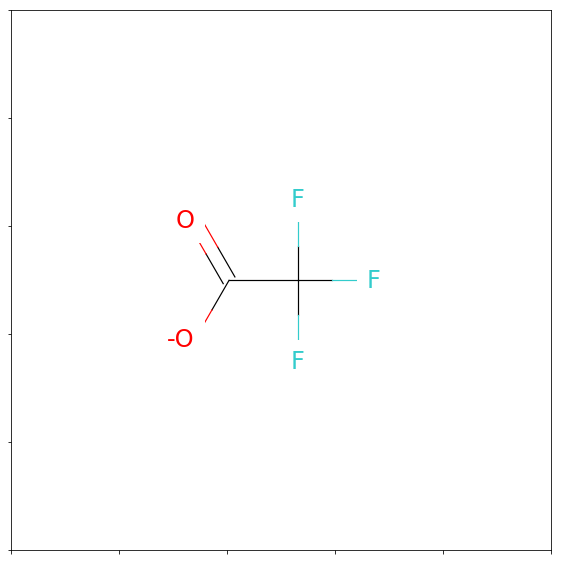

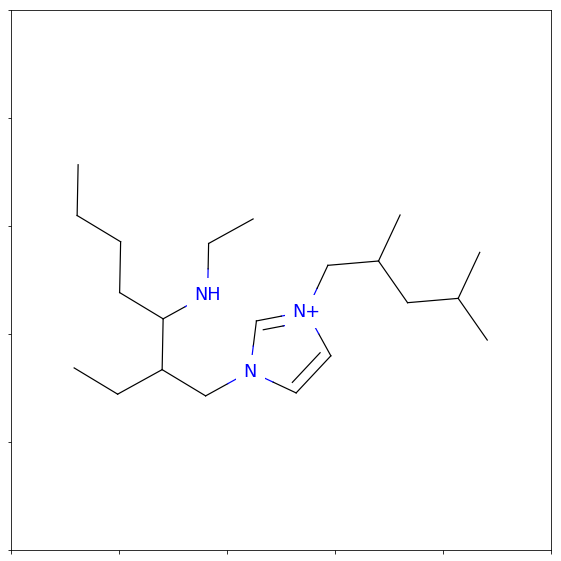

In [4]:
def guess_password(target):
    startTime = datetime.datetime.now()

    def fnGetFitness(genes):
        return get_fitness(anion, genes, target)

    def fnDisplay(candidate, mutation):
        display(candidate, mutation, startTime)

    def fnShowIon(genes, target, mutation_attempts):
        show_ion(genes, target, mutation_attempts)

    optimalFitness = 0.99
    best = genetic.get_best(fnGetFitness,\
        optimalFitness, geneSet, fnDisplay,\
                    fnShowIon, target)
    return best
    
def display(candidate, mutation, startTime):
    timeDiff = datetime.datetime.now() - startTime
    print("{}\t{}\t{}".format(
    candidate.Genes, candidate.Fitness, mutation))
    
def get_fitness(anion, genes, target):
    cation = Chem.MolFromSmiles(genes)
    #anion = Chem.MolFromSmiles("[B-](F)(F)(F)F")
    model = genetic.load_data("density_nn_model.sav", pickleFile=True)
    deslist = genetic.load_data("density_nn_model_descriptors.csv")
    feature_vector=[]
    with genetic.suppress_stdout_stderr():
        for item in deslist:
            if "anion" in item:
                feature_vector.append(calculator([item.partition('-')\
                    [0]]).CalcDescriptors(anion)[0])
            elif "cation" in item:
                feature_vector.append(calculator([item.partition('-')\
                [0]]).CalcDescriptors(cation)[0])          
            elif "Temperature_K" in item:
                feature_vector.append(298.15)
            elif "Pressure_kPa" in item:
                feature_vector.append(101.325)
            else:
                print("unknown descriptor in list: %s" % item)
    features_normalized = (feature_vector-deslist.iloc[0].values)/deslist.iloc[1].values
    prediction = exp(model.predict(np.array(features_normalized).reshape(1,-1))[0])
    error = abs((prediction-target)/target)
    
    return 1-error

def show_ion(genes, target, mutation_attempts):
    print("{}\t{}".format("mutation attempts: ", mutation_attempts))
    print("within 1%% of target density: %s (kg/m) " % target)
    

geneSet = genetic.generate_geneset()
df = genetic.load_data("saltInfo.csv")
df = df['anion_SMILES'].unique()
ohPickMe = random.sample(range(df.shape[0]),1)
anion = Chem.MolFromSmiles(df[ohPickMe[0]])
print(df[ohPickMe[0]])
img = Draw.MolToMPL(anion)
target = random.sample(range(800,1500),1)[0]
print(target)
best = guess_password(target)
img = Draw.MolToMPL(best.Mol)

In [8]:
df

array([ '(C6=C(C5(C)C)C7=CC=CC=C7C=C6)CCCC)(C)C.C(C(F)(F)[P-](C(C(F)(F)F)(F)F)(C(C(F)(F)F)(F)F)(F)(F)F)(F)(F)F',
       'C(F)(F)(F)S(=O)(=O)[O-]', 'C(=O)(C(F)(F)F)[O-]',
       'C(=C(C#N)C#N)=[N-]', 'C(#N)[S-]', '[B-](F)(F)(F)F',
       'OCl(=O)(=O)=O', 'COS(=O)(=O)[O-]', 'CS(=O)(=O)O', '[I-]',
       'F[P-](F)(F)(F)(F)F', 'CCOS(=O)(=O)[O-]', 'C(#N)[N-]C#N', '[Cl-]',
       '[Br-]', 'C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F',
       'C(C(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(C(F)(F)F)(F)F)(F)(F)F',
       'CC(=O)[O-]', 'C(C(F)(F)S(=O)(=O)NS(=O)(=O)C(C(F)(F)F)(F)F)(F)(F)F',
       'C(C(F)(F)[P-](C(C(F)(F)F)(F)F)(C(C(F)(F)F)(F)F)(F)(F)F)(F)(F)F',
       'CC1=CC=C(C=C1)S(=O)(=O)[O-]'], dtype=object)

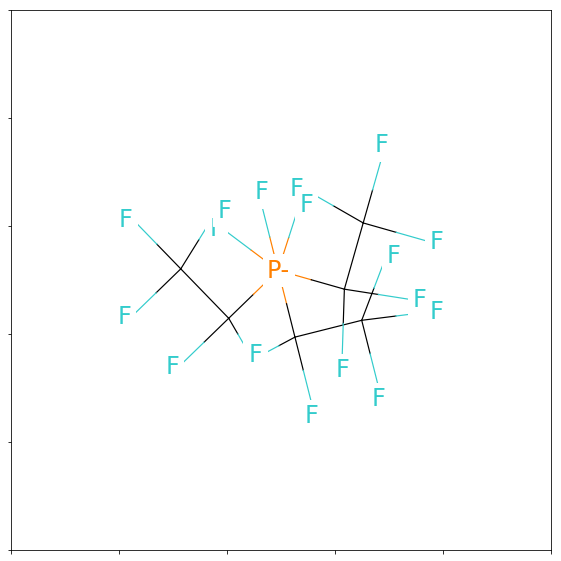

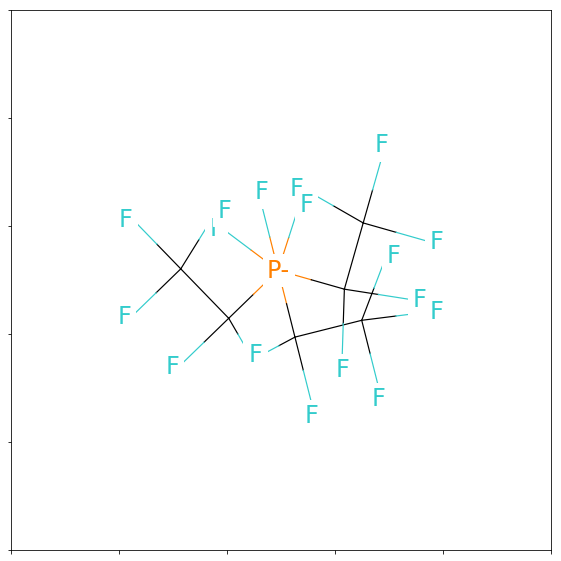

In [43]:
Draw.MolToMPL(Chem.MolFromSmiles("C(C(F)(F)[P-](C(C(F)(F)F)(F)F)(C(C(F)(F)F)(F)F)(F)(F)F)(F)(F)F"))

In [110]:
#imports
from math import exp
import numpy as np
from rdkit.ML.Descriptors.MoleculeDescriptors import\
    MolecularDescriptorCalculator as calculator
    
#Load the pickled NN model and associated descriptors
model = load_data("density_nn_model.sav", pickleFile=True)
deslist = load_data("density_nn_model_descriptors.csv")

#Load rdkit descriptor calculator, set exp conditions, choose
#a cation/anion
cation = Chem.MolFromSmiles("CCCCCCCCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC")
anion = Chem.MolFromSmiles("[Cl-]")
Temperature = 298.15
Pressure = 101.325

#recreate the feature vector for the salt
feature_vector=[]
for item in deslist:
    if "anion" in item:        
        feature_vector.append(calculator([item.partition('-')[0]]).CalcDescriptors(anion)[0])
    elif "cation" in item:
        feature_vector.append(calculator([item.partition('-')[0]]).CalcDescriptors(cation)[0])
    elif "Temperature_K" in item:
        feature_vector.append(Temperature)
    elif "Pressure_kPa" in item:
        feature_vector.append(Pressure)
    else:
        print("unknown descriptor in list: %s" % item)
vec = (feature_vector-deslist.iloc[0].values)/deslist.iloc[1].values

#predict with model
exp(model.predict(np.array(vec).reshape(1,-1))[0])

891.6218755332308

(<matplotlib.figure.Figure at 0x7fd8eee00ac8>, 0.30555555555555547)

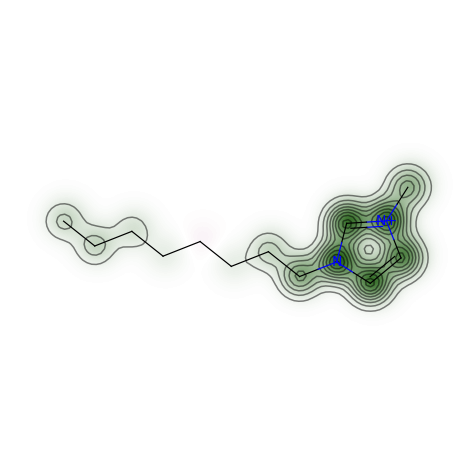

In [27]:
geneSet = genetic.generate_geneset()
df = genetic.load_data("saltInfo.csv")
df = df.loc[df["cation_name"].str.contains("imid", case=False)]
df = df['cation_SMILES'].unique()
ohPickMe = random.sample(range(df.shape[0]),2)
target = Chem.MolFromSmiles(df[ohPickMe[0]])
candidate = Chem.MolFromSmiles(df[ohPickMe[1]])
%matplotlib inline
SimilarityMaps.GetSimilarityMapForFingerprint(candidate,\
        target,SimilarityMaps.GetMorganFingerprint)